In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mysg # Tom Robitaille's YSO grid tool
from astropy.table import Table

from astropy.io import fits
from astropy import units as u, constants
import pylab as pl
import requests

from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, atmo_model, molecule_data
del molecule_data['h2o_b']

from astropy.visualization import simple_norm


In [2]:
cd ../smart-plotters

/blue/adamginsburg/savannahgramze/cloudc/smart-plotters/smart-plotters


In [3]:
from jwst_plots import JWSTCatalog, make_cat_use
from glimpse_plots import GlimpseCatalog
from cutout_plot import Cutout

In [4]:
cd ../notebooks

/blue/adamginsburg/savannahgramze/cloudc/smart-plotters/notebooks


In [5]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg
from dust_extinction.parameter_averages import CCM89
from astroquery.svo_fps import SvoFps


# Filter Abs

In [6]:
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [7]:
instrument = 'NIRCam'
telescope = 'JWST'
filt466 = 'F466N'
#filt470 = 'F470N'
wavelength_table_466 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt466}')
#wavelength_table_470 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt470}')
wavelength_table_410 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.F410M')
wavelength_table_405 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.F405N')

wavelength_tables_jwst = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['F466N', 'F410M', 'F405N']}

Text(0, 0.5, 'Transmission')

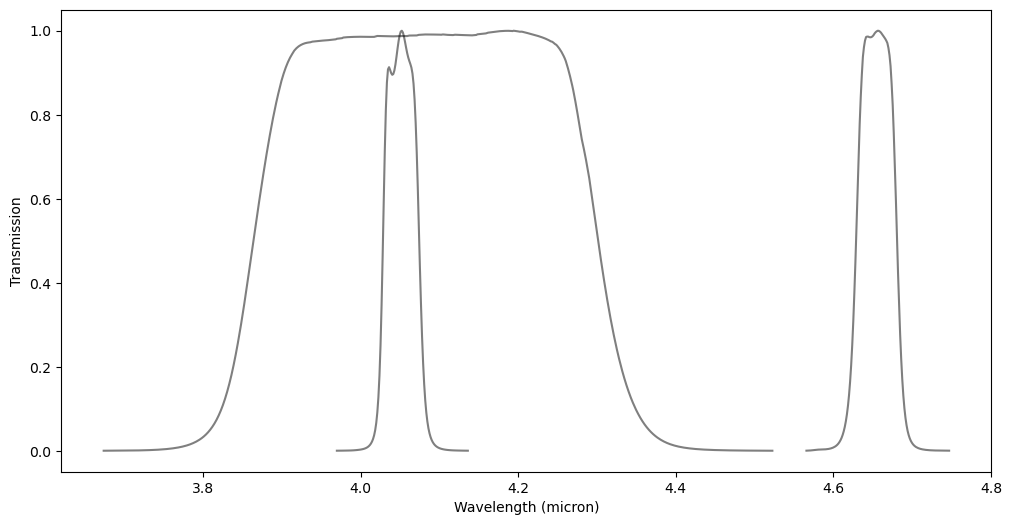

In [8]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_jwst.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [9]:
instrument = 'IRAC'
telescope = 'Spitzer'
wavelength_tables_spitzer = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                             for filt in ['I1', 'I2', 'I3', 'I4']}

wavelength_tables = {#'f470n': wavelength_table_470,
                     'f466n': wavelength_table_466,
                     'f410m': wavelength_table_410,
                     'f405n': wavelength_table_405,
                    }
wavelength_tables.update(wavelength_tables_spitzer)

Text(0, 0.5, 'Transmission')

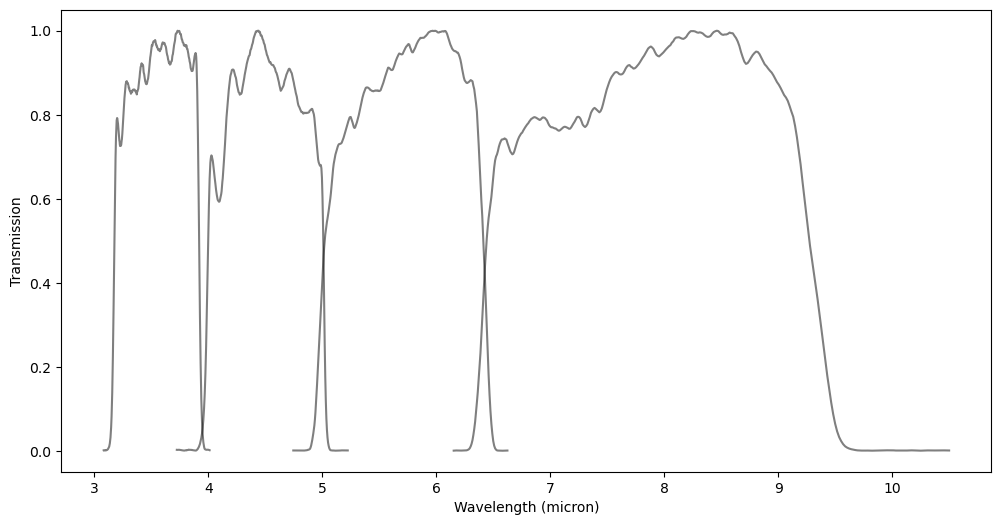

In [ ]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_spitzer.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [11]:
instrument = 'WISE'
telescope = 'WISE'
wavelength_tables_wise = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['W1', 'W2', 'W3', 'W4']}

Text(0, 0.5, 'Transmission')

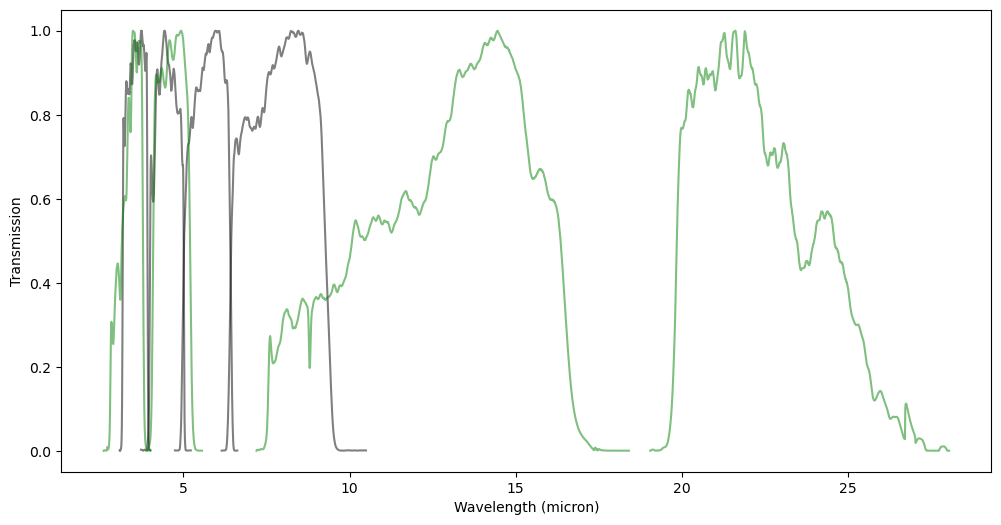

In [12]:
fig = plt.figure(figsize=(12, 6))

#for filt, tbl in wavelength_tables_jwst.items():
#    xarr = tbl['Wavelength'].quantity.to(u.micron)
#    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

for filt, tbl in wavelength_tables_spitzer.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='g', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

Text(0, 0.5, 'Transmission')

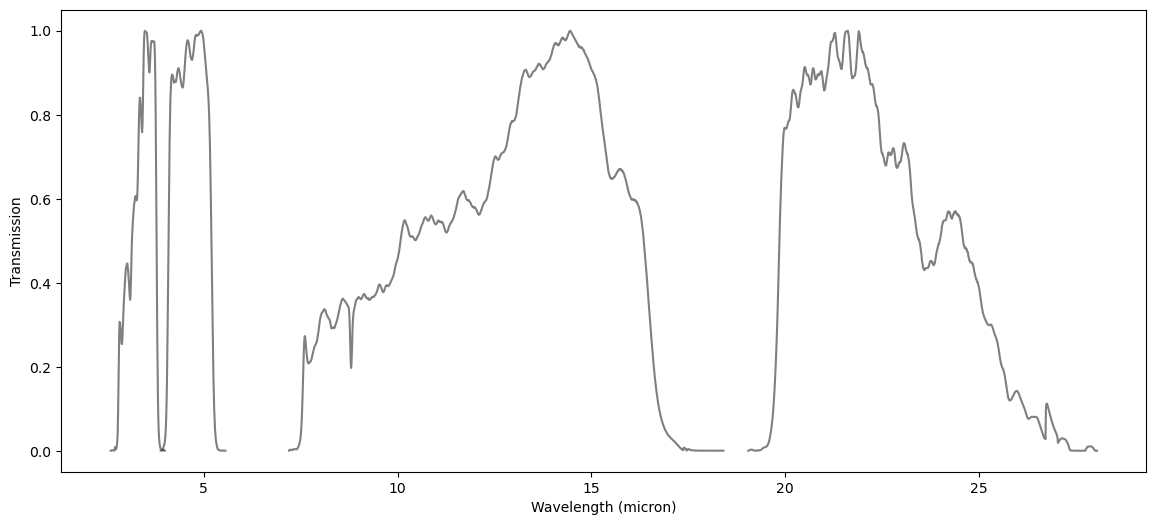

In [13]:
fig = plt.figure(figsize=(14, 6))

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

In [14]:
instrument = '2MASS'
telescope = '2MASS'
wavelength_tables_2mass = {filt: SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
                          for filt in ['J', 'H', 'Ks']}

Text(0, 0.5, 'Transmission')

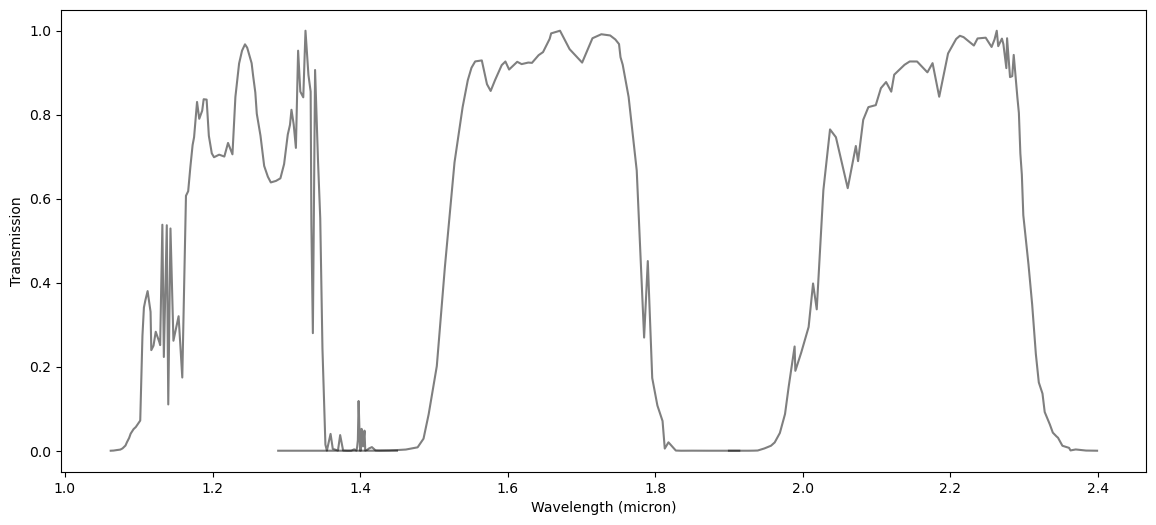

In [15]:
fig = plt.figure(figsize=(14, 6))

for filt, tbl in wavelength_tables_2mass.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='k', alpha=0.5, label=filt)

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')

# Ice Absorption

In [16]:
import icemodels.core
import importlib as imp
imp.reload(icemodels.core)
from icemodels.core import (phx4000, absorbed_spectrum, absorbed_spectrum_Gaussians, convsum,
                            fluxes_in_filters,
                            univap_molecule_data,
                            load_molecule, load_molecule_ocdb, load_molecule_univap, read_ocdb_file,
                            atmo_model, molecule_data)
from astropy import log
log.setLevel('DEBUG')
ice_model_table = load_molecule_ocdb('ch3oh.10k')
log.setLevel('INFO')

DEBUG: molecule name = ch3oh.10k, ID=https://ocdb.smce.nasa.gov/dataset/78 [icemodels.core]


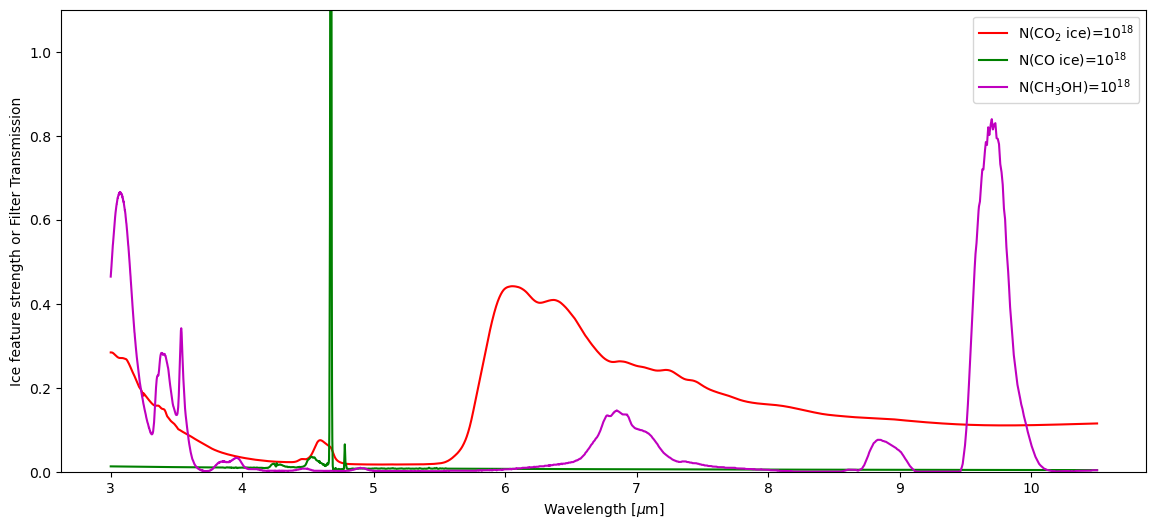

In [17]:
fig = plt.figure(figsize=(14, 6))
xarr = np.linspace(3.0, 10.5, int(5e4))*u.um

mol = load_molecule_ocdb('co2')
mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='r', label='N(CO$_2$ ice)=10$^{18}$')

#mol = load_molecule_ocdb('co')
optical_constants_cache_dir = '/red/adamginsburg/repos/icemodels/icemodels/data/'
baratta_co = read_ocdb_file(f'{optical_constants_cache_dir}/1_CO_(1)_12.5K_Baratta.txt')
#mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
mod = absorbed_spectrum(1e18*u.cm**-2, baratta_co, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='g', label='N(CO ice)=10$^{18}$')

#mol = load_molecule_ocdb('h2o:ch3oh:co:nh3.100:10:1:1.10k')
#mol = load_molecule_ocdb('h2o.10k')
#mod = absorbed_spectrum(1e19*u.cm**-2, mol, return_tau=True, xarr=xarr)
#plt.plot(xarr, mod, color='b', label='N(H$_2$O)=10$^{19}$')

mol = load_molecule_ocdb('ch3oh.10k')
mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='m', label='N(CH$_3$OH)=10$^{18}$')

plt.ylim(0,1.1)
plt.xlabel(f"Wavelength [$\\mu$m]")
plt.ylabel("Ice feature strength or Filter Transmission")
plt.legend()

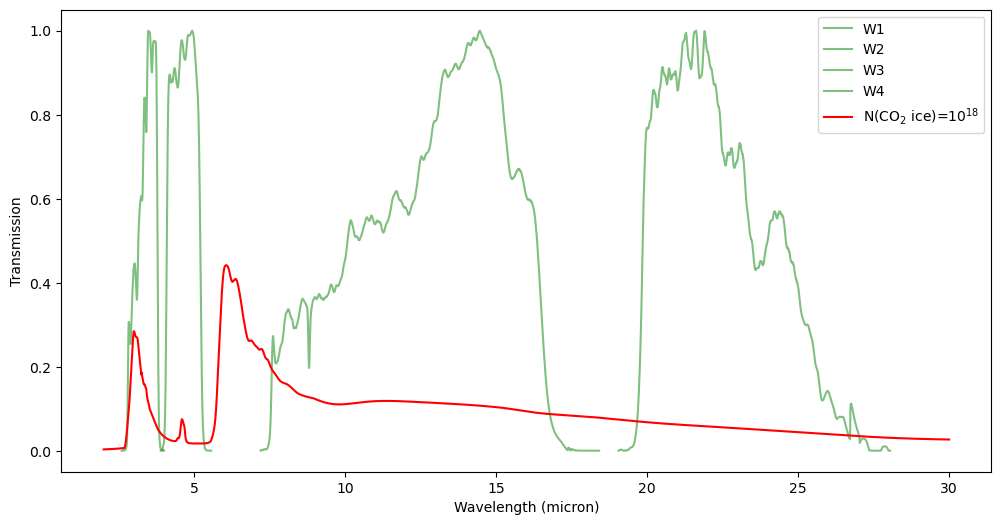

In [18]:
fig = plt.figure(figsize=(12, 6))

for filt, tbl in wavelength_tables_wise.items():
    xarr = tbl['Wavelength'].quantity.to(u.micron)
    plt.plot(xarr, tbl['Transmission']/tbl['Transmission'].max(), color='g', alpha=0.5, label=filt)

xarr = np.linspace(2.0, 30, int(5e4))*u.um
mol = load_molecule_ocdb('co2')
mod = absorbed_spectrum(1e18*u.cm**-2, mol, return_tau=True, xarr=xarr)
plt.plot(xarr, mod, color='r', label='N(CO$_2$ ice)=10$^{18}$')

plt.xlabel('Wavelength (micron)')
plt.ylabel('Transmission')
plt.legend()

# Catalogs

In [19]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import regions

In [20]:
coord_BC2 = SkyCoord(3.0970501246, 0.3112008170, unit=(u.deg, u.deg), frame='galactic')
width = 42*u.arcmin
length = 40*u.arcmin
reg_BC2 = regions.RectangleSkyRegion(center=coord_BC2, width=width, height=length, angle=0*u.deg)

In [21]:
#cat_spitzer = GlimpseCatalog(Vizier.get_catalogs('II/293')[0])
Vizier.ROW_LIMIT = 1e6#2e5
cat_spitzer = GlimpseCatalog(Vizier.query_region(coord_BC2, radius=40*u.arcmin, catalog='II/293')[0])

In [22]:
cat_spitzer.catalog

GLIMPSE,RAJ2000,DEJ2000,C,2MASS,Jmag,Hmag,Kmag,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag
,deg,deg,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
str17,float64,float64,str1,str16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
G002.5123-00.0086,267.879315,-26.788264,C,,--,--,--,12.772,0.069,12.467,0.073,--,--,--,--
G002.5138-00.0097,267.881265,-26.787543,C,17513149-2647151,--,14.038,12.859,12.011,0.037,12.058,0.051,11.744,0.096,12.116,0.294
G002.5139-00.0106,267.882137,-26.787935,C,,--,--,--,13.492,0.066,13.435,0.100,--,--,--,--
G002.5147-00.0114,267.883366,-26.787656,C,,--,--,--,14.160,0.081,14.052,0.161,--,--,--,--
G002.5147-00.0100,267.882080,-26.786900,C,,--,--,--,13.292,0.048,13.302,0.102,--,--,--,--
G002.5152-00.0122,267.884472,-26.787652,A,,--,--,--,13.863,0.116,13.812,0.144,--,--,--,--
G002.5163-00.0157,267.888422,-26.788448,C,,--,--,--,13.255,0.067,13.313,0.094,--,--,--,--
G002.5164-00.0102,267.883165,-26.785569,C,17513195-2647080,--,13.899,12.749,12.025,0.038,11.878,0.067,11.542,0.060,--,--


<AxesSubplot: xlabel='[K] - [3.6]', ylabel='[3.6] - [4.5]'>

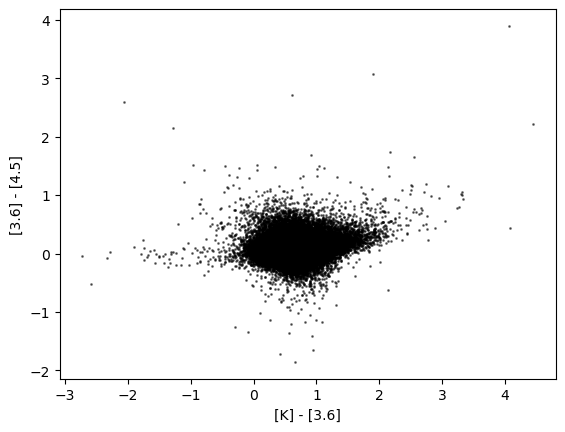

In [23]:
cat_spitzer.plot_CCD('K', '3.6', '3.6', '4.5', color='k', alpha=0.5, s=1)

<AxesSubplot: xlabel='[K] - [3.6]', ylabel='[4.5] - [5.8]'>

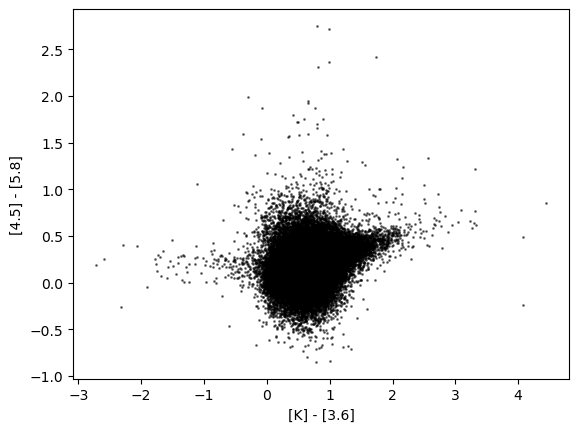

In [24]:
cat_spitzer.plot_CCD('K', '3.6', '4.5', '5.8', color='k', alpha=0.5, s=1)

/blue/adamginsburg/adamginsburg/repos/mpl_plot_templates/mpl_plot_templates/adaptive_param_plot.py:129: UserWarning: The following kwargs were not used by contour: 'markersize'
  con = axis.contour(cx,cy,H.T,levels=levels,norm=norm,cmap=cmap,**kwargs)


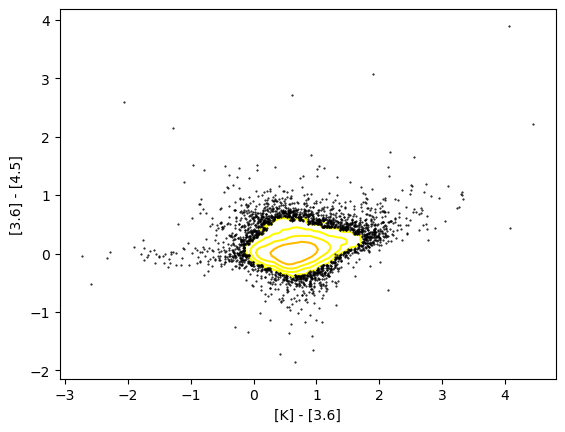

In [25]:
ax = plt.subplot()
#cat_spitzer.plot_CCD('K', '3.6', '3.6', '4.5', color='red', s=2)
cat_spitzer.plot_contour_CCD('K', '3.6', '3.6', '4.5', threshold=15)
#ax.set_ylim(-2, 3)

/blue/adamginsburg/adamginsburg/repos/mpl_plot_templates/mpl_plot_templates/adaptive_param_plot.py:129: UserWarning: The following kwargs were not used by contour: 'markersize'
  con = axis.contour(cx,cy,H.T,levels=levels,norm=norm,cmap=cmap,**kwargs)


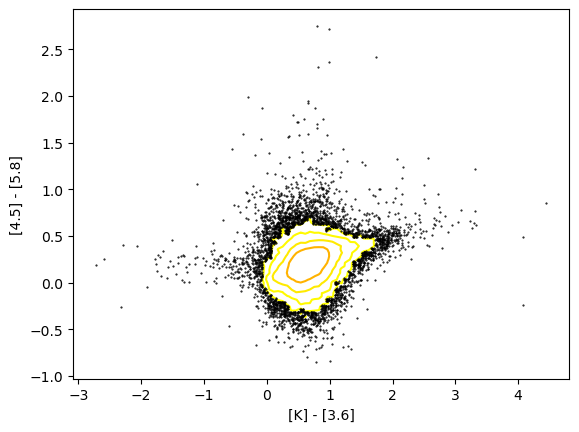

In [28]:
ax = plt.subplot()
#cat_spitzer.plot_CCD('K', '3.6', '3.6', '4.5', color='red', s=2)
cat_spitzer.plot_contour_CCD('K', '3.6', '4.5', '5.8', threshold=15)
#ax.set_ylim(-2, 3)

<AxesSubplot: xlabel='[K] - [4.5]', ylabel='[K]'>

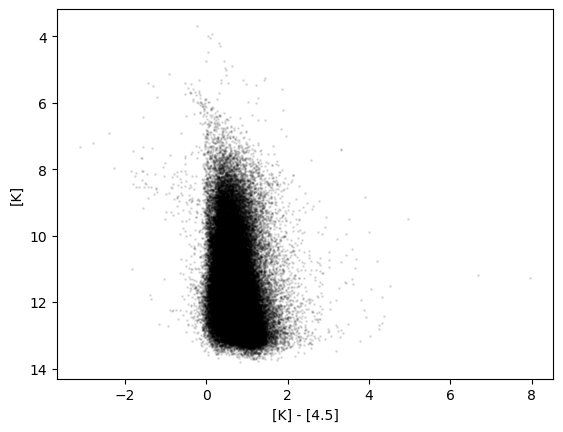

In [32]:
ax = plt.subplot()
cat_spitzer.plot_CMD('K', '4.5', 'K', color='k', alpha=0.1, s=1, ax=ax)

In [26]:
bc2_cutout = Cutout(coord_BC2, l=width, w=length)
bc2_cut = bc2_cutout.get_cutout('/orange/adamginsburg/cmz/galacticbar/bania2/spitzer/GLM_00300+0000_mosaic_I4.fits')

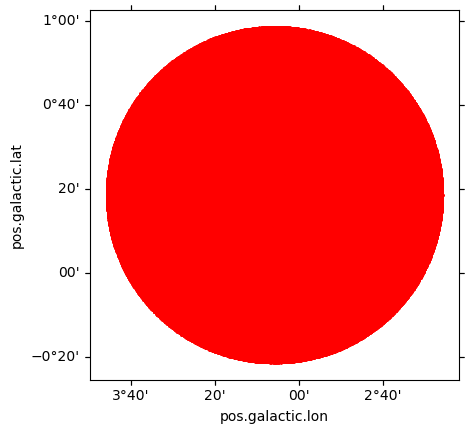

In [27]:
ax = plt.subplot(projection=bc2_cut.wcs)
ax.imshow(bc2_cut.data, origin='lower', cmap='gray', norm=simple_norm(bc2_cut.data, stretch='log', max_percent=99.9))
ax.scatter(cat_spitzer.coords.galactic.l, cat_spitzer.coords.galactic.b, transform=ax.get_transform('world'), s=1, color='r')